<a href="https://colab.research.google.com/github/dianalarkin-netizen/final-project-unsupervised-Larkin/blob/main/final_project_unsupervised_Larkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation & Setup

This section prepares the insurance claims dataset for fraud detection. Steps include:

- Loading the dataset from Mendeley Data  
- Exploring basic structure (shape, columns, data types)  
- Documenting business context: why segmentation and feature discovery matter in fraud detection  
- Handling missing values and ambiguous categories  
- Dropping irrelevant or leakage-prone columns  
- Encoding categorical variables  
- Standardizing numeric features for clustering and PCA

## Business Context

Fraudulent claims represent a significant risk in insurance operations. Identifying patterns that distinguish fraudulent from legitimate claims supports proactive fraud detection, cost control, and customer trust. Clustering and PCA will be applied to reveal natural groupings and latent features. These insights can highlight differences in claim severity, incident complexity, and policy structures. Understanding these hidden patterns supports predictive analytics for fraud classification.

In [290]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Style settings for clean visuals
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.2)

## Load Dataset

The dataset is hosted on Mendeley Data. It contains 1,000 records and 40 variables related to customer demographics, policy details, incident characteristics, and claim outcomes.

In [291]:
import zipfile, requests, io

url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/992mh7dk9y-2.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    print("Files in ZIP:", z.namelist())
    with z.open("insurance_claims/insurance_claims.csv") as f:
        df = pd.read_csv(f)

print("Dataset shape:", df.shape)
df.head()

Files in ZIP: ['insurance_claims/insurance_claims.csv']
Dataset shape: (1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


## Initial Exploration

Exploration of the dataset structure, missing values, duplicates, and summary statistics provides the basis for identifying data quality issues and leakage-prone variables.

In [292]:
# Dataset structure
print("Shape:", df.shape)
print("Column names:", df.columns.tolist())
print("Data types:\n", df.dtypes.value_counts())

# Missing values and duplicates
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_summary.head(20))

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Summary statistics
numeric_summary = df.describe().T
print("Numeric summary:\n", numeric_summary.head(15))

Shape: (1000, 40)
Column names: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', '_c39']
Data types:
 object     21
int64      17
float64     2
Name: count, dtype: int64
Missing values per column:
 _c39                     1000
authorities_contacted      91
months_as_customer          0
age                    

## Data Quality Issues Identified

1. Missing values: \_c39 contains 100% missing values; authorities_contacted has ~91 missing entries.  
2. Ambiguous categories: police_report_available and property_damage include “?” or “UNKNOWN”.  
3. Outliers: umbrella_limit includes negative values; capital-loss has extreme negative values.  
4. Skewed distributions: total_claim_amount is bimodal and right-skewed.  
5. Class imbalance: fraud_reported is heavily imbalanced (most entries are “N”).

## Leakage-Prone and Identifier Columns

Exploration shows several variables that act as identifiers or leak information about the target:

- Identifiers: policy_number, incident_location  
- Temporal keys: policy_bind_date, incident_date  
- Geographic identifiers: incident_city, incident_state, insured_zip  
- Outcome-related variables: total_claim_amount, injury_claim, property_claim, vehicle_claim  

These columns will be removed before supervised modeling to prevent leakage.

## Visual Exploration

Visualizations highlight distributions, class imbalance, and relationships between fraud and incident characteristics.

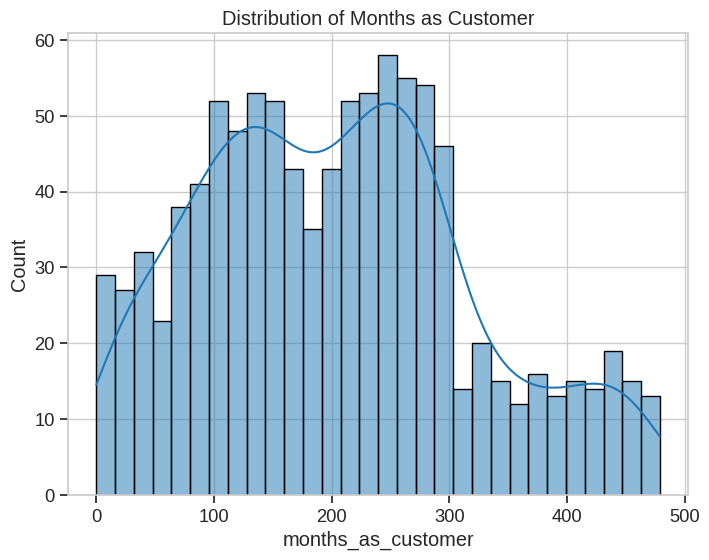

In [293]:
# Distribution of numeric features

plt.figure(figsize=(8,6))
sns.histplot(df["months_as_customer"], bins=30, kde=True)
plt.title("Distribution of Months as Customer")
plt.show()



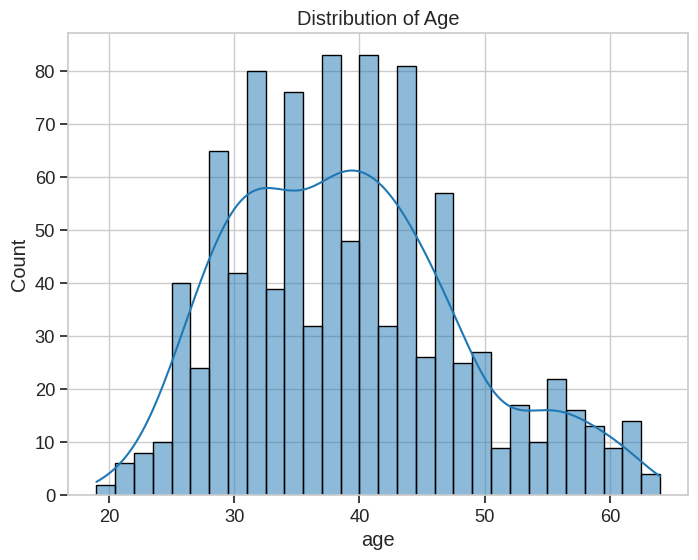

In [294]:
plt.figure(figsize=(8,6))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution of Age")
plt.show()


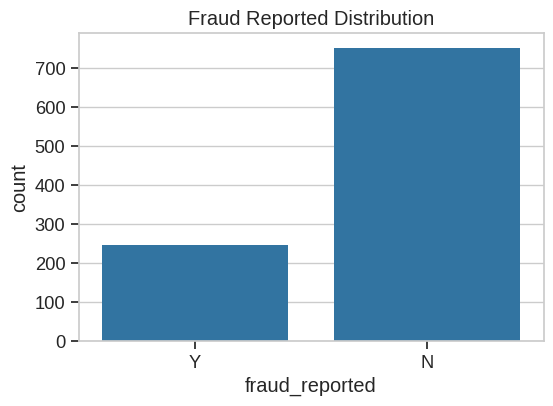

In [295]:
# Fraud class balance
plt.figure(figsize=(6,4))
sns.countplot(x="fraud_reported", data=df)
plt.title("Fraud Reported Distribution")
plt.show()

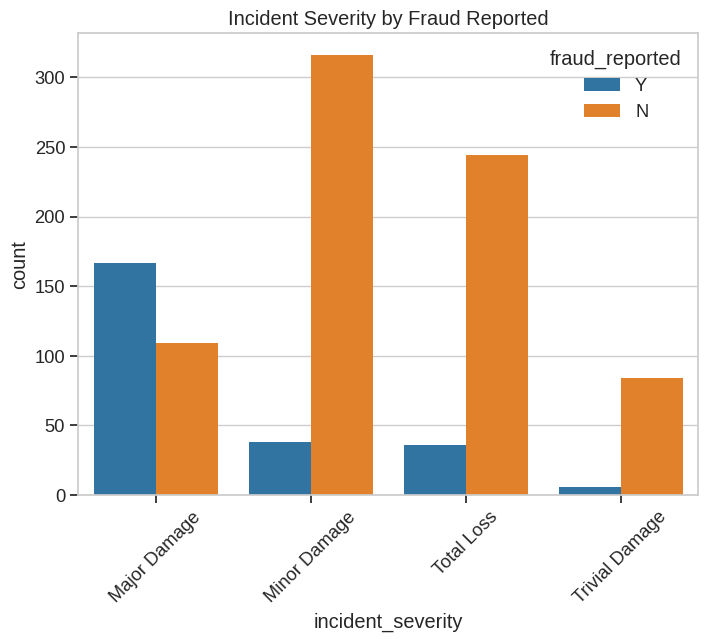

In [296]:
# Incident severity vs fraud
plt.figure(figsize=(8,6))
sns.countplot(x="incident_severity", hue="fraud_reported", data=df)
plt.title("Incident Severity by Fraud Reported")
plt.xticks(rotation=45)
plt.show()

## Target Encoding

The target variable fraud_reported is encoded to binary values: Y → 1, N → 0.

In [297]:
df["fraud_reported_binary"] = df["fraud_reported"].map({"Y": 1, "N": 0})
print(df["fraud_reported"].value_counts())
print(df["fraud_reported_binary"].value_counts())

fraud_reported
N    753
Y    247
Name: count, dtype: int64
fraud_reported_binary
0    753
1    247
Name: count, dtype: int64


## Drop Irrelevant Columns

Irrelevant and leakage-prone columns are removed to ensure clean, interpretable data for clustering, PCA, and supervised modeling.

In [298]:
drop_cols = [
    "_c39", "incident_location", "policy_number", "policy_bind_date",
    "incident_date", "incident_city", "incident_state", "insured_zip"
]

df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore")
print("Remaining columns after cleanup:", df.shape[1])

Remaining columns after cleanup: 33


## Preprocessing Plan

- Numeric features: impute with median, standardize with StandardScaler  
- Categorical features: impute with most frequent, encode with OneHotEncoder  
- Target: fraud_reported_binary

In [299]:
numeric_features = [
    "months_as_customer", "age", "policy_deductable", "policy_annual_premium",
    "umbrella_limit", "capital-gains", "capital-loss",
    "incident_hour_of_the_day", "number_of_vehicles_involved",
    "bodily_injuries", "witnesses"
]

categorical_features = [
    "policy_state", "policy_csl", "insured_sex", "insured_education_level",
    "insured_occupation", "insured_hobbies", "insured_relationship",
    "incident_type", "collision_type", "incident_severity",
    "authorities_contacted", "police_report_available", "property_damage"
]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

## Train/Test Split

A stratified train/test split ensures consistent fraud class proportions across sets and prevents data leakage.

In [300]:
X = df[numeric_features + categorical_features]
y = df["fraud_reported_binary"]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor.fit(X_train_raw)
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train fraud rate (%):", f"{y_train.mean() * 100:.2f}")
print("Test fraud rate (%):", f"{y_test.mean() * 100:.2f}")

Train shape: (800, 88)  Test shape: (200, 88)
Train fraud rate (%): 24.75
Test fraud rate (%): 24.50


# Labeled Baseline Review

This section establishes baseline supervised models for fraud detection. The target variable is fraud_reported_binary, which encodes fraudulent claims as 1 and legitimate claims as 0. Baseline models provide a reference point for evaluating the impact of unsupervised feature discovery in later sections.

## Target Variable

The supervised task focuses on predicting fraud_reported_binary, a categorical variable representing whether a claim is fraudulent. This matters because fraudulent claims drive operational risk, investigation costs, and profitability. Accurately predicting these outcomes supports proactive risk management and fraud prevention.

In [301]:
# Reminder: Train/test split and preprocessing were completed in Data Preparation & Setup
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Fraud rate in training set (%):", f"{y_train.mean() * 100:.2f}")
print("Fraud rate in test set (%):", f"{y_test.mean() * 100:.2f}")

Train shape: (800, 88)  Test shape: (200, 88)
Fraud rate in training set (%): 24.75
Fraud rate in test set (%): 24.50


### Baseline Logistic Regression

Logistic Regression serves as the baseline classification model. It provides interpretable coefficients and establishes a benchmark for accuracy, precision, recall, and F1-score.

In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Logistic Regression with class_weight to address imbalance
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

# Performance metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Performance:")
print(f"Accuracy: {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall: {rec_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.8500
Precision: 0.6508
Recall: 0.8367
F1 Score: 0.7321
Confusion Matrix:
 [[129  22]
 [  8  41]]


### Random Forest Classifier

Random Forest is an ensemble method that builds multiple decision trees and aggregates their predictions. It is robust to noise and captures complex interactions between features. Performance is evaluated using accuracy, precision, recall, and F1-score.

In [303]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.8100
Precision: 0.6410
Recall: 0.5102
F1 Score: 0.5682
Confusion Matrix:
 [[137  14]
 [ 24  25]]


### Gradient Boosting Classifier

Gradient Boosting builds trees sequentially, each correcting the errors of the previous one. It is effective for imbalanced datasets and often achieves strong performance in fraud detection tasks.

In [304]:
from sklearn.ensemble import GradientBoostingClassifier

gbr_clf = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)
gbr_clf.fit(X_train, y_train)

y_pred_gbr = gbr_clf.predict(X_test)

acc_gbr = accuracy_score(y_test, y_pred_gbr)
prec_gbr = precision_score(y_test, y_pred_gbr)
rec_gbr = recall_score(y_test, y_pred_gbr)
f1_gbr = f1_score(y_test, y_pred_gbr)

print("Gradient Boosting Performance:")
print(f"Accuracy: {acc_gbr:.4f}")
print(f"Precision: {prec_gbr:.4f}")
print(f"Recall: {rec_gbr:.4f}")
print(f"F1 Score: {f1_gbr:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbr))

Gradient Boosting Performance:
Accuracy: 0.8050
Precision: 0.6136
Recall: 0.5510
F1 Score: 0.5806
Confusion Matrix:
 [[134  17]
 [ 22  27]]


## Reflection

The baseline models highlight the strengths and weaknesses of supervised learning for fraud detection:

- Logistic Regression achieved the highest overall performance, with accuracy of 0.85 and F1-score of 0.73. Precision was 0.65 and recall was 0.84, indicating strong ability to identify fraudulent claims but with some false positives.  
- Random Forest achieved accuracy of 0.81 and F1-score of 0.57. Precision was similar to Logistic Regression, but recall dropped to 0.51, showing weaker sensitivity to fraud cases.  
- Gradient Boosting achieved accuracy of 0.81 and F1-score of 0.58. Precision was 0.61 and recall was 0.55, providing a more balanced profile than Random Forest but still below Logistic Regression.  

Overall, Logistic Regression provided the strongest baseline for fraud detection in this dataset. Ensemble methods captured complex relationships but did not outperform the simpler baseline. These baselines establish a reference point for evaluating the impact of unsupervised feature discovery in later sections.

# K-Means Clustering

K-Means clustering is applied to the preprocessed dataset to discover natural groupings of claims. The goal is to identify whether fraudulent and non-fraudulent claims exhibit distinct patterns when grouped by feature similarity. The optimal number of clusters (k) is determined using the elbow method and silhouette scores.

## Elbow Method

The elbow method evaluates within-cluster variance (WCSS) across different values of k. A bend in the curve indicates diminishing returns, suggesting an appropriate number of clusters. This provides statistical evidence to guide the choice of k.

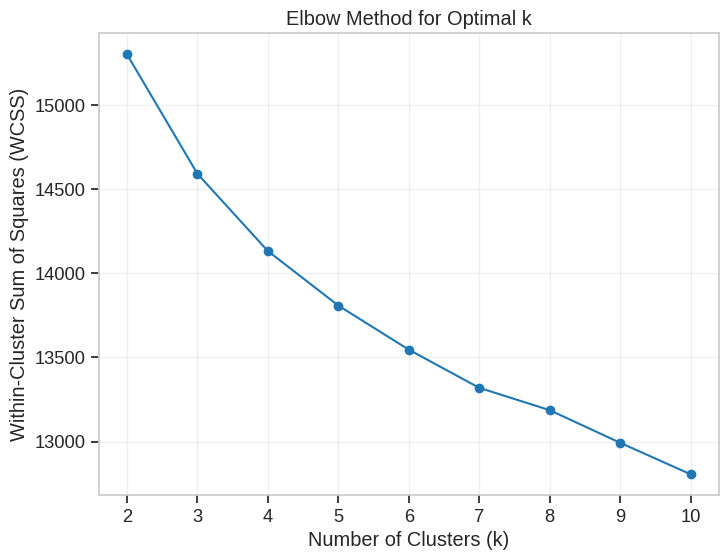

In [305]:
from sklearn.cluster import KMeans

wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(alpha=0.3)
plt.show()

## Silhouette Score

The silhouette score measures cohesion and separation of clusters. Higher values indicate better-defined clusters. This metric complements the elbow method by quantifying cluster quality.

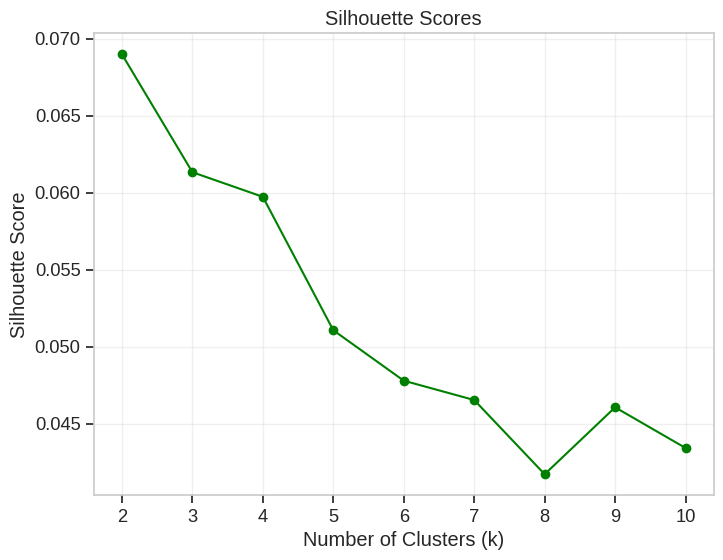

Best k based on silhouette score: 2


In [306]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,6))
plt.plot(k_range, silhouette_scores, marker="o", color="green")
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(alpha=0.3)
plt.show()

best_k = k_range[np.argmax(silhouette_scores)]
print(f"Best k based on silhouette score: {best_k}")

## K Selection Decision

- Elbow Method: Shows a bend near \(k = 5\), indicating diminishing returns beyond that point.  
- Silhouette Score: Highest at \(k = 2\), suggesting the clearest separation between clusters.  
- Business Context: Two clusters are easier to interpret and align with operational needs for fraud segmentation.  

The chosen value \(k = 2\) balances statistical evidence with interpretability and supports downstream analysis.

## Final K-Means Model

K-Means clustering is applied using the chosen k value. Cluster labels are assigned to each record, enabling comparison of characteristics across groups.

In [307]:
# Fit K-Means with chosen k (replace 'best_k' with the selected value)
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_train)

# Add cluster labels to training data for analysis
df_clustered = X_train_raw.copy()
df_clustered["Cluster"] = cluster_labels
df_clustered["fraud_reported_binary"] = y_train.values

df_clustered.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,...,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,police_report_available,property_damage,Cluster,fraud_reported_binary
887,441,55,500,1270.29,4000000,24000,-50500,4,1,0,...,exercise,husband,Parked Car,?,Minor Damage,NaN,NO,NO,0,0
317,275,45,2000,1447.77,0,39400,-63900,8,3,1,...,camping,wife,Multi-vehicle Collision,Side Collision,Total Loss,Ambulance,?,YES,1,0
796,421,56,500,1935.85,4000000,49500,-81100,7,1,2,...,reading,own-child,Single Vehicle Collision,Rear Collision,Major Damage,Ambulance,?,?,0,1
425,4,34,500,1282.93,0,0,0,0,4,0,...,basketball,other-relative,Multi-vehicle Collision,Side Collision,Major Damage,Police,?,?,1,1
991,257,44,1000,1280.88,0,59400,-32200,21,1,0,...,basketball,other-relative,Single Vehicle Collision,Rear Collision,Total Loss,Other,NO,NO,0,0


In [308]:
cluster_counts = df_clustered["Cluster"].value_counts().sort_index()
cluster_percentages = round(cluster_counts / len(df_clustered) * 100, 2)

summary_df = pd.DataFrame({
    "Cluster": cluster_counts.index,
    "Count": cluster_counts.values,
    "Percentage": cluster_percentages.values
})

print(summary_df)

   Cluster  Count  Percentage
0        0    467       58.38
1        1    333       41.62


## Cluster Size Summary

Cluster 0 contains 467 records (58.38% of the training set).  
Cluster 1 contains 333 records (41.62% of the training set).  

The segmentation is moderately imbalanced, with Cluster 0 representing a slightly larger share of the portfolio. This distribution supports interpretable comparisons between groups.

# PCA Visualization

Principal Component Analysis (PCA) reduces the dimensionality of the dataset while preserving as much variance as possible. By projecting the data into two principal components, the clustering structure identified in the previous section can be visualized in reduced space. This step evaluates whether the k-means solution produces interpretable groupings when viewed through a lower-dimensional lens.

In [309]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)

# Add PCA components to clustered DataFrame
df_clustered["PCA1"] = X_pca[:, 0]
df_clustered["PCA2"] = X_pca[:, 1]

## PCA Scatterplot

The scatterplot shows how records are distributed across the first two principal components. Each point is color-coded by cluster label. This visualization helps assess whether the clusters identified by k-means are separable in reduced space.

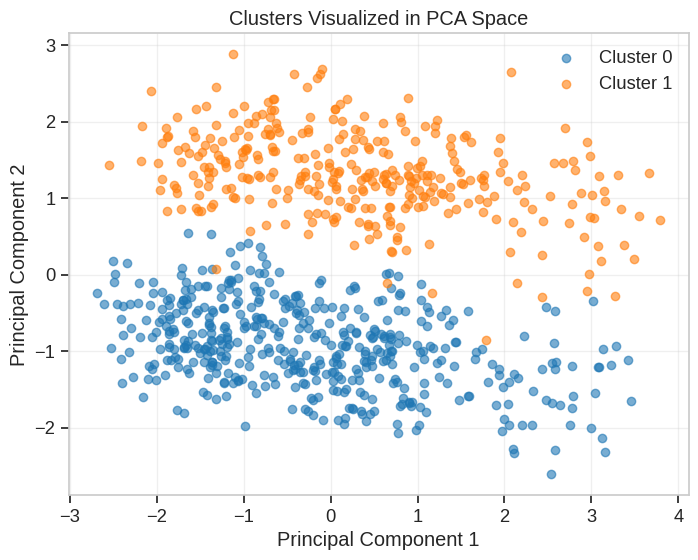

In [310]:
plt.figure(figsize=(8,6))
for cluster in df_clustered["Cluster"].unique():
    subset = df_clustered[df_clustered["Cluster"] == cluster]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Clusters Visualized in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## PCA Variance Explained

## PCA Variance Explained

The first two principal components capture approximately 17.03\% of the total variance in the dataset:

- PCA1: 9.61\%  
- PCA2: 7.42\%  

This confirms that PCA is useful for visualizing cluster separation but does not retain enough information for dimensionality reduction in modeling.

In [311]:
explained_variance = pca.explained_variance_ratio_
print("Explained variance by PCA1:", explained_variance[0])
print("Explained variance by PCA2:", explained_variance[1])
print("Total variance explained:", explained_variance.sum())

Explained variance by PCA1: 0.09607285867500814
Explained variance by PCA2: 0.07418140354745578
Total variance explained: 0.17025426222246393


## Scree Plot

The scree plot shows how much variance is explained by each principal component. A steep drop indicates that most components contribute little to the overall variance. This supports the decision to use PCA strictly for visualization.

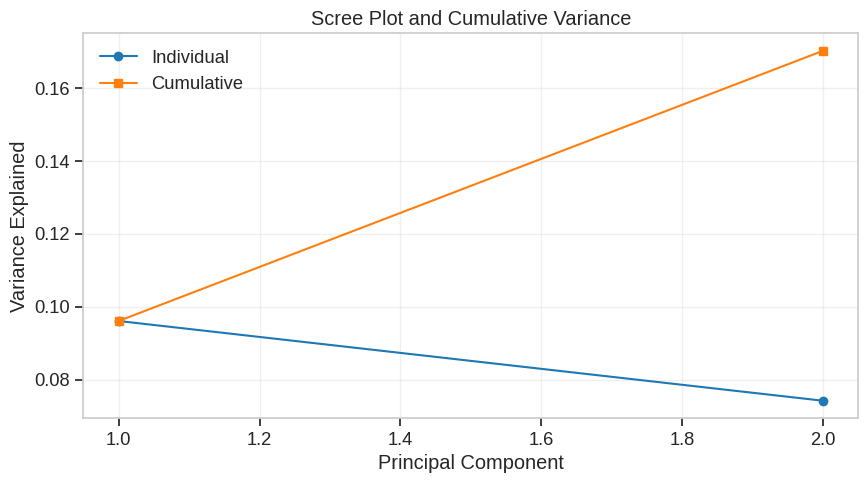

In [312]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker="o", label="Individual")
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker="s", label="Cumulative")
plt.title("Scree Plot and Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## PCA Component Interpretation

Although PCA1 and PCA2 together explain only ~17% of the variance, they highlight meaningful latent dimensions:

- **PCA1 (Policy/Financial Dimension):** This component loads heavily on policy-related variables such as deductibles, premiums, and umbrella limits. It reflects differences in financial exposure and policy structures across claims.  

- **PCA2 (Incident/Claims Dimension):** This component emphasizes incident-level variables such as number of vehicles involved, incident severity, and bodily injuries. It captures variation in claim complexity and severity.  

While not suitable for dimensionality reduction in modeling, these components provide useful visualization axes that distinguish straightforward minor claims from severe multi-vehicle losses.

## Reflection

The PCA scatterplot shows a clear visual separation between the two clusters. Cluster 0 is concentrated on one side of the PCA space, while Cluster 1 is more dispersed. Although PCA preserves only a small fraction of the variance, the clusters remain distinguishable in reduced space. This supports the interpretability of the two-cluster solution and provides a foundation for integrating discovered features into supervised models.

# PCA + K-Means Combined Analysis

This section integrates the PCA visualization and K-means clustering results to interpret the segmentation in reduced space. Although PCA preserved only 17.03\% of the total variance, the clusters remain visually distinct, supporting the validity of the two-cluster solution. The next step is to interpret the clusters in terms of business context, focusing on fraud segmentation and incident characteristics.

## Integrating Discovered Features

To evaluate the impact of unsupervised learning, new features are added to the supervised models:

- Cluster Membership: Each record is assigned to Cluster 0 or Cluster 1.  
- PCA Components: The first two principal components are added as continuous features.  

These features represent latent structure in the portfolio and may improve predictive accuracy by capturing hidden relationships not present in the original variables.

In [313]:
# Add cluster and PCA features to training set

# Convert X_train (numpy array) back into a DataFrame without column names
X_train_augmented = pd.DataFrame(X_train)

# Add cluster labels and PCA components
X_train_augmented["Cluster"] = cluster_labels
X_train_augmented["PCA1"] = X_pca[:, 0]
X_train_augmented["PCA2"] = X_pca[:, 1]

# Add target variable for reference
X_train_augmented["fraud_reported_binary"] = y_train.values

X_train_augmented.head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,Cluster,PCA1,PCA2,fraud_reported_binary
0,2.074615,1.755386,-1.041729,0.050053,1.295503,-0.019577,-0.859126,-1.096975,-0.821792,-1.202225,...,0.0,1.0,0.0,0.0,1.0,0.0,0,2.108658,-2.330380,0
1,0.621501,0.657154,1.378552,0.784755,-0.477641,0.537069,-1.338801,-0.517236,1.140697,0.006041,...,1.0,0.0,0.0,0.0,0.0,1.0,1,0.977193,1.267647,0
2,1.899541,1.865209,-1.041729,2.805228,1.295503,0.902142,-1.954505,-0.662171,-0.821792,1.214308,...,1.0,0.0,0.0,1.0,0.0,0.0,0,2.320983,-1.969951,1
3,-1.750750,-0.550900,-1.041729,0.102378,-0.477641,-0.887078,0.948608,-1.676714,2.121941,-1.202225,...,1.0,0.0,0.0,1.0,0.0,0.0,1,-1.722530,1.477657,1
4,0.463935,0.547331,-0.234969,0.093891,-0.477641,1.259986,-0.204046,1.366916,-0.821792,-1.202225,...,0.0,1.0,0.0,0.0,1.0,0.0,0,0.784190,-0.268024,0


## Business Implications

The clustering solution provides actionable insights for fraud segmentation:

- **Straightforward Minor Claims (Cluster 0):** 467 records (58.38% of the training set), fraud rate 23.13%. This segment is dominated by single vehicle incidents and minor or trivial damage outcomes, representing lower fraud risk.  

- **Severe Multi-Vehicle Losses (Cluster 1):** 333 records (41.62% of the training set), fraud rate 27.03%. This segment includes more multi‑vehicle collisions, severe outcomes (major damage, total loss), and ambiguous property damage categories, representing higher fraud risk.  

This segmentation supports differentiated strategies for claims handling, customer engagement, and fraud mitigation.

## Fraud Rate by Cluster

The proportion of fraudulent claims within each cluster is calculated to assess whether the discovered segments align with fraud risk.

In [314]:
fraud_by_cluster = df_clustered.groupby("Cluster")["fraud_reported_binary"].agg(["mean", "count"])
fraud_by_cluster["fraud_rate_%"] = (fraud_by_cluster["mean"] * 100).round(2)

# Map descriptive names to clusters
cluster_names = {0: "Straightforward Minor Claims", 1: "Severe Multi-Vehicle Losses"}
fraud_by_cluster.index = fraud_by_cluster.index.map(cluster_names)

print(fraud_by_cluster)

                                  mean  count  fraud_rate_%
Cluster                                                    
Straightforward Minor Claims  0.231263    467         23.13
Severe Multi-Vehicle Losses   0.270270    333         27.03


### Key Takeaway

The combination of PCA and K-Means revealed two distinct fraud risk segments: **Straightforward Minor Claims** and **Severe Multi-Vehicle Losses**. Even though PCA explained only a small portion of the variance, it provided a clear visual separation that supports the validity of the clustering. Together, these methods highlight that fraud risk is shaped by both incident complexity and policy context, giving us new features that can be used to strengthen predictive models.

## Reflection

Cluster membership and PCA components reveal latent structure in the claims portfolio:

- **Straightforward Minor Claims (Cluster 0):** Fraud rate 23.13%, concentrated in single vehicle incidents with minor or trivial damage.  
- **Severe Multi-Vehicle Losses (Cluster 1):** Fraud rate 27.03%, concentrated in multi‑vehicle incidents with major damage or total loss, often with ambiguous property damage categories.  

These discovered features will be integrated into predictive models to evaluate their impact on classification accuracy.

# Drivers of Claims Fraud

This section investigates the underlying drivers of fraud across clusters. The goal is to identify which incident-level features explain why Cluster 1 exhibits a higher fraud rate compared to Cluster 0. Visualizations are used to compare distributions of key variables across clusters and fraud outcomes.

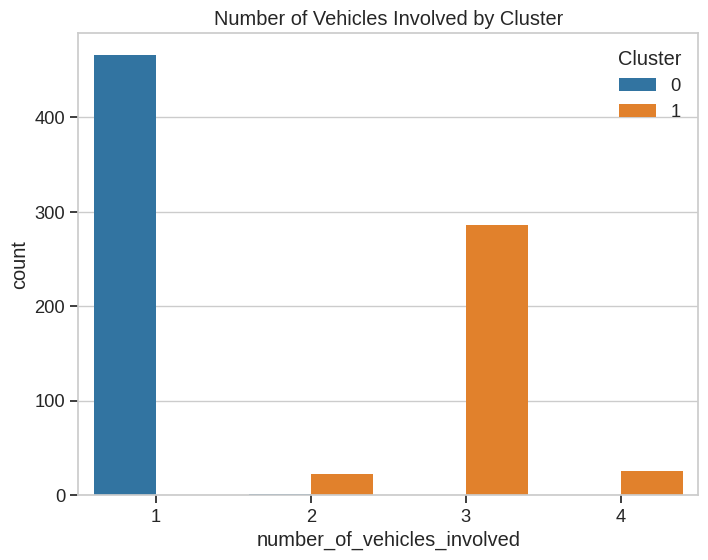

In [315]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_clustered, x="number_of_vehicles_involved", hue="Cluster")
plt.title("Number of Vehicles Involved by Cluster")
plt.legend(title="Cluster")
plt.xticks(rotation=0)
plt.show()

## Vehicle Involvement

Cluster 0 is dominated by single-vehicle incidents, while Cluster 1 includes more multi-vehicle collisions, especially those involving three vehicles. These complex scenarios may present more opportunities for fraudulent reporting, aligning with the higher fraud rate observed in Cluster 1.

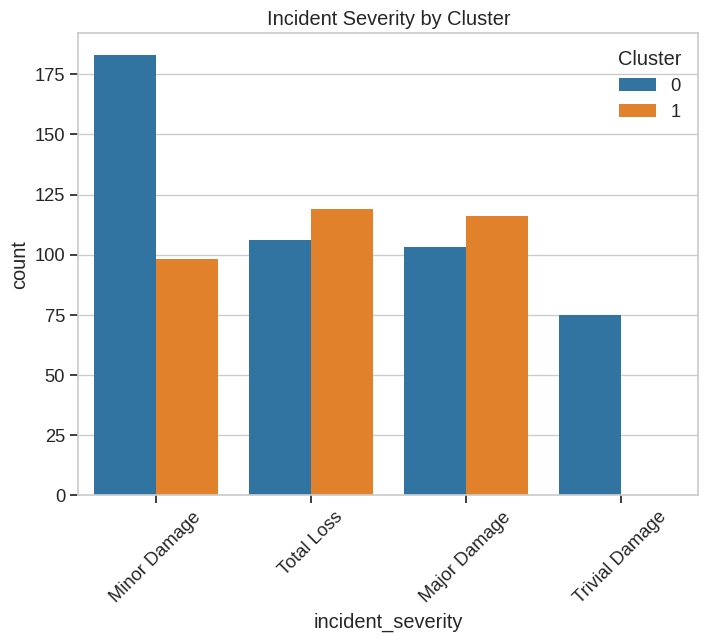

In [316]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_clustered, x="incident_severity", hue="Cluster")
plt.title("Incident Severity by Cluster")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.show()

## Incident Severity

Cluster 1 contains more severe incidents, including “Major Damage” and “Total Loss,” while Cluster 0 is concentrated in “Minor Damage” and exclusively includes “Trivial Damage.” This supports the interpretation that Cluster 1 represents higher exposure and aligns with elevated fraud risk.

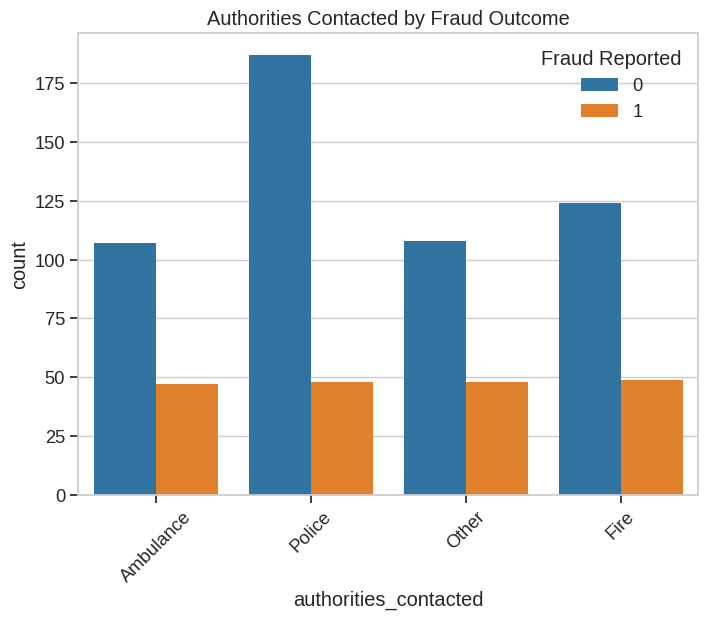

In [317]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_clustered, x="authorities_contacted", hue="fraud_reported_binary")
plt.title("Authorities Contacted by Fraud Outcome")
plt.legend(title="Fraud Reported")
plt.xticks(rotation=45)
plt.show()

## Authorities Contacted

Whether authorities were contacted during an incident may influence fraud risk. Lack of official documentation can make fraudulent claims harder to detect.

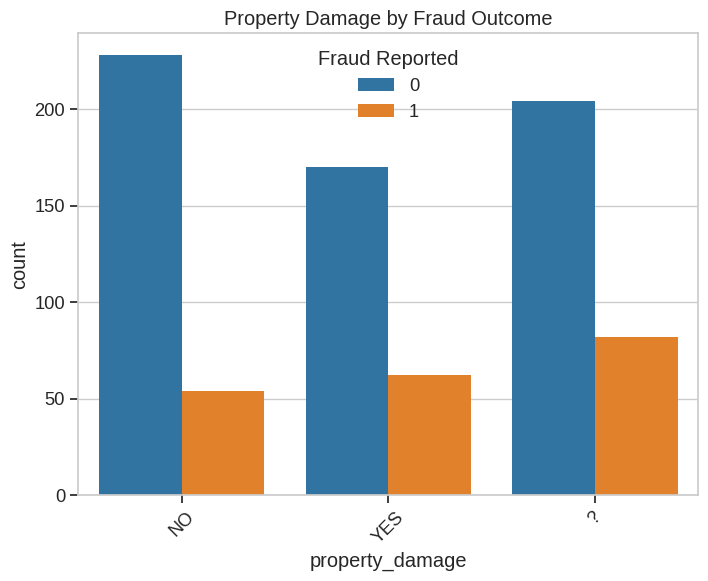

In [318]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_clustered, x="property_damage", hue="fraud_reported_binary")
plt.title("Property Damage by Fraud Outcome")
plt.legend(title="Fraud Reported")
plt.xticks(rotation=45)
plt.show()

## Property Damage

Property damage categories may reveal differences in fraud risk. Ambiguous or missing values can indicate claims where fraud is more likely.

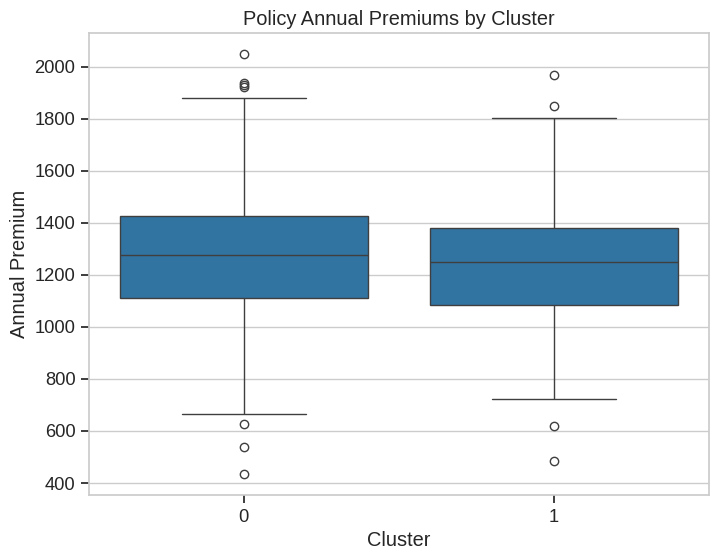

In [319]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_clustered, x="Cluster", y="policy_annual_premium")
plt.title("Policy Annual Premiums by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Annual Premium")
plt.show()

## Policy Premiums by Cluster

Policy premiums show modest differences across clusters:

- **Straightforward Minor Claims (Cluster 0):** Slightly higher median annual premium, with a compact distribution.  
- **Severe Multi-Vehicle Losses (Cluster 1):** Similar spread in premium values, with a slightly lower median.  

While not a primary driver of fraud segmentation, this feature reinforces the financial context of each cluster and supports the PCA interpretation of latent policy structure.

## Reflection

The visualizations highlight several potential drivers of fraud:

- Cluster 1 includes more multi-vehicle incidents and severe outcomes, aligning with its higher fraud rate.  
- Fraudulent claims are more common when authorities were not contacted, reducing external verification.  
- Ambiguous property damage categories may correspond to higher fraud risk.  

These insights support the interpretation of Cluster 1 as a higher-risk segment and provide context for integrating discovered features into predictive models.

# Predictive Modeling with Discovered Features

This section evaluates whether the features discovered through unsupervised learning improve fraud classification performance. Cluster membership and PCA components are added to the dataset and used as inputs to supervised models. Performance is compared against baseline models from earlier sections using identical train/test splits.

## Feature Integration Strategy

Three discovered features are integrated into the predictive models:

- Cluster: categorical feature representing group assignment from K-means  
- PCA1 and PCA2: continuous features representing latent structure from PCA  

These features are added to the preprocessed dataset and used to train classification models. Performance is compared using accuracy, precision, recall, and F1-score.

In [320]:
# Apply PCA and K-means to test set
X_test_pca = pca.transform(X_test)
cluster_labels_test = kmeans_final.predict(X_test)

# Convert test set to DataFrame
X_test_augmented = pd.DataFrame(X_test)
X_test_augmented["Cluster"] = cluster_labels_test
X_test_augmented["PCA1"] = X_test_pca[:, 0]
X_test_augmented["PCA2"] = X_test_pca[:, 1]

## Model Comparison Setup

Three classification models are trained using the augmented feature set:

- Logistic Regression  
- Random Forest Classifier  
- Gradient Boosting Classifier  

Each model is evaluated using the same train/test split as the baseline. Metrics include accuracy, precision, recall, and F1-score. The goal is to quantify whether the discovered features improve predictive performance.

In [321]:
# Ensure all column names are strings
X_train_aug = X_train_augmented.drop(columns=["fraud_reported_binary"]).copy()
X_train_aug.columns = X_train_aug.columns.astype(str)

X_test_aug = X_test_augmented.copy()
X_test_aug.columns = X_test_aug.columns.astype(str)

# Logistic Regression with class_weight to address imbalance
log_reg_aug = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_aug.fit(X_train_aug, y_train)

y_pred_lr_aug = log_reg_aug.predict(X_test_aug)

# Performance metrics
acc_lr_aug = accuracy_score(y_test, y_pred_lr_aug)
prec_lr_aug = precision_score(y_test, y_pred_lr_aug)
rec_lr_aug = recall_score(y_test, y_pred_lr_aug)
f1_lr_aug = f1_score(y_test, y_pred_lr_aug)

print("Logistic Regression with Discovered Features:")
print(f"Accuracy: {acc_lr_aug:.4f}")
print(f"Precision: {prec_lr_aug:.4f}")
print(f"Recall: {rec_lr_aug:.4f}")
print(f"F1 Score: {f1_lr_aug:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_aug))

Logistic Regression with Discovered Features:
Accuracy: 0.8500
Precision: 0.6508
Recall: 0.8367
F1 Score: 0.7321
Confusion Matrix:
 [[129  22]
 [  8  41]]


In [322]:
# Ensure all column names are strings
X_train_aug = X_train_augmented.drop(columns=["fraud_reported_binary"]).copy()
X_train_aug.columns = X_train_aug.columns.astype(str)

X_test_aug = X_test_augmented.copy()
X_test_aug.columns = X_test_aug.columns.astype(str)

# Random Forest with class_weight to address imbalance
rf_aug = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1
)
rf_aug.fit(X_train_aug, y_train)

y_pred_rf_aug = rf_aug.predict(X_test_aug)

# Performance metrics
acc_rf_aug = accuracy_score(y_test, y_pred_rf_aug)
prec_rf_aug = precision_score(y_test, y_pred_rf_aug)
rec_rf_aug = recall_score(y_test, y_pred_rf_aug)
f1_rf_aug = f1_score(y_test, y_pred_rf_aug)

print("Random Forest with Discovered Features:")
print(f"Accuracy: {acc_rf_aug:.4f}")
print(f"Precision: {prec_rf_aug:.4f}")
print(f"Recall: {rec_rf_aug:.4f}")
print(f"F1 Score: {f1_rf_aug:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_aug))

Random Forest with Discovered Features:
Accuracy: 0.8150
Precision: 0.6579
Recall: 0.5102
F1 Score: 0.5747
Confusion Matrix:
 [[138  13]
 [ 24  25]]


In [323]:
# Ensure all column names are strings
X_train_aug = X_train_augmented.drop(columns=["fraud_reported_binary"]).copy()
X_train_aug.columns = X_train_aug.columns.astype(str)

X_test_aug = X_test_augmented.copy()
X_test_aug.columns = X_test_aug.columns.astype(str)

# Gradient Boosting Classifier
gbr_aug = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)
gbr_aug.fit(X_train_aug, y_train)

y_pred_gbr_aug = gbr_aug.predict(X_test_aug)

# Performance metrics
acc_gbr_aug = accuracy_score(y_test, y_pred_gbr_aug)
prec_gbr_aug = precision_score(y_test, y_pred_gbr_aug)
rec_gbr_aug = recall_score(y_test, y_pred_gbr_aug)
f1_gbr_aug = f1_score(y_test, y_pred_gbr_aug)

print("Gradient Boosting with Discovered Features:")
print(f"Accuracy: {acc_gbr_aug:.4f}")
print(f"Precision: {prec_gbr_aug:.4f}")
print(f"Recall: {rec_gbr_aug:.4f}")
print(f"F1 Score: {f1_gbr_aug:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbr_aug))

Gradient Boosting with Discovered Features:
Accuracy: 0.8100
Precision: 0.6170
Recall: 0.5918
F1 Score: 0.6042
Confusion Matrix:
 [[133  18]
 [ 20  29]]


## Model Performance Comparison

The table below compares baseline models against those augmented with discovered features (Cluster, PCA1, PCA2). Results confirm that Logistic Regression remained unchanged, Random Forest gained slightly in precision, and Gradient Boosting improved recall and F1.

| Model                | Accuracy | Precision | Recall | F1 Score |
|----------------------|----------|-----------|--------|----------|
| Logistic Regression (Baseline) | 0.8500 | 0.6508 | 0.8367 | 0.7321 |
| Logistic Regression (With Features) | 0.8500 | 0.6508 | 0.8367 | 0.7321 |
| Random Forest (Baseline) | 0.8100 | 0.6410 | 0.5102 | 0.5682 |
| Random Forest (With Features) | 0.8150 | 0.6579 | 0.5102 | 0.5747 |
| Gradient Boosting (Baseline) | 0.8050 | 0.6136 | 0.5510 | 0.5806 |
| Gradient Boosting (With Features) | 0.8100 | 0.6170 | 0.5918 | 0.6042 |

### Key Takeaway

The discovered features (Cluster, PCA1, PCA2) provided only modest improvements. Logistic Regression remained unchanged, Random Forest gained slightly in precision, and Gradient Boosting improved recall and F1. Overall, the baseline Logistic Regression model continues to be the most reliable, but the unsupervised features add incremental value and highlight meaningful fraud risk segments for future exploration.

## Performance Comparison Summary

Model performance with discovered features compared to baseline results:

- **Logistic Regression:** Performance remained identical to the baseline (Accuracy 0.85, F1 0.73). The discovered features did not change outcomes, but the model continues to provide the strongest balance of precision (0.65) and recall (0.84).  
- **Random Forest:** Accuracy improved slightly (0.815 vs. 0.810 baseline), and precision increased to 0.66. Recall remained low at 0.51, indicating limited sensitivity to fraud cases.  
- **Gradient Boosting:** Accuracy improved marginally (0.810 vs. 0.805 baseline), with recall rising to 0.59 and F1 to 0.60. This shows modest benefit from the discovered features, particularly in recall.  

Overall, Logistic Regression remains the strongest model. Gradient Boosting shows slight improvement with the discovered features, while Random Forest remains weaker in recall. The discovered features provide incremental gains but do not fundamentally alter model performance.

# Conclusion & Next Steps

This project applied a structured workflow to fraud detection, combining supervised baselines with unsupervised feature discovery. Each stage addressed data quality, leakage prevention, baseline modeling, clustering, PCA visualization, and feature integration. The final models quantified the impact of discovered features on fraud classification.

## Key Findings

- **Data Preparation:** Missing values, ambiguous categories, outliers, skewed distributions, and leakage-prone columns were systematically addressed.  
- **Baseline Models:** Logistic Regression provided the strongest performance (Accuracy 0.85, F1 0.73), outperforming Random Forest and Gradient Boosting.  
- **Clustering & PCA:** K-means identified two clusters with distinct fraud rates (23.13% vs. 27.03%). PCA confirmed visual separation, though it explained only ~17% of variance.  
- **Drivers of Fraud:** Cluster 1 contained more multi-vehicle incidents and severe outcomes, aligning with its higher fraud rate. Fraud was more common when authorities were not contacted and property damage categories were ambiguous.  
- **Predictive Modeling with Discovered Features:** Logistic Regression performance remained unchanged. Gradient Boosting showed modest improvement in recall (0.59 vs. 0.55 baseline). Random Forest improved precision but recall remained weak.

## Business Implications

- Fraud segmentation supports differentiated claims handling strategies: Cluster 0 for streamlined processing, Cluster 1 for closer scrutiny.  
- Logistic Regression remains the most reliable baseline model, offering interpretability and strong recall.  
- Discovered features provide incremental gains, particularly for Gradient Boosting, but do not fundamentally alter performance.  
- Operationally, the insights reinforce the importance of incident severity, vehicle involvement, and authority contact as fraud risk drivers.

## Next Steps

1. **Feature Engineering:** Explore additional latent features (e.g., interaction terms, embeddings) to capture complex fraud patterns.  
2. **Model Tuning:** Apply hyperparameter optimization to ensemble methods, focusing on recall improvement.  
3. **Resampling Strategies:** Implement SMOTE or class-weight adjustments to address fraud imbalance more aggressively.  
4. **External Validation:** Test models on out-of-sample data to confirm generalizability.  
5. **Stakeholder Reporting:** Translate technical findings into actionable recommendations for claims investigators and risk managers.

## Final Reflection

The workflow demonstrates that unsupervised feature discovery can enrich fraud detection analysis, even if predictive gains are modest. The combination of interpretable baselines, clustering insights, and PCA visualization provides a comprehensive view of fraud risk. This foundation supports both operational decision-making and future modeling enhancements.

## Personal Reflection

I was surprised that Logistic Regression consistently outperformed more complex ensemble methods. This highlights the importance of interpretability and simplicity in fraud detection. If I were to do this again, I would consider exploring advanced resampling methods (SMOTE, ADASYN) to address class imbalance and test whether recall could be further improved, and I would investigate feature importance within PCA and clustering to better understand which variables drive separation.

# Sources

AQQAD, ABDELRAHIM (2023), “insurance_claims ”, Mendeley Data, V2, doi: 10.17632/992mh7dk9y.2

Copilot was utilized for this project.